In [ ]:
#initial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

sns.set(style="whitegrid")

df = pd.read_csv("../data/raw_analyst_ratings.csv")

df.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [2]:
# Convert date to datetime with UTC offset handled
df["date"] = pd.to_datetime(df["date"], utc=True, errors="coerce")

# Drop rows with missing headlines
df = df.dropna(subset=["headline"])

# Remove odd spaces
df["headline"] = df["headline"].str.strip()


In [3]:
df["headline_length"] = df["headline"].apply(len)

df["headline_length"].describe()


count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64

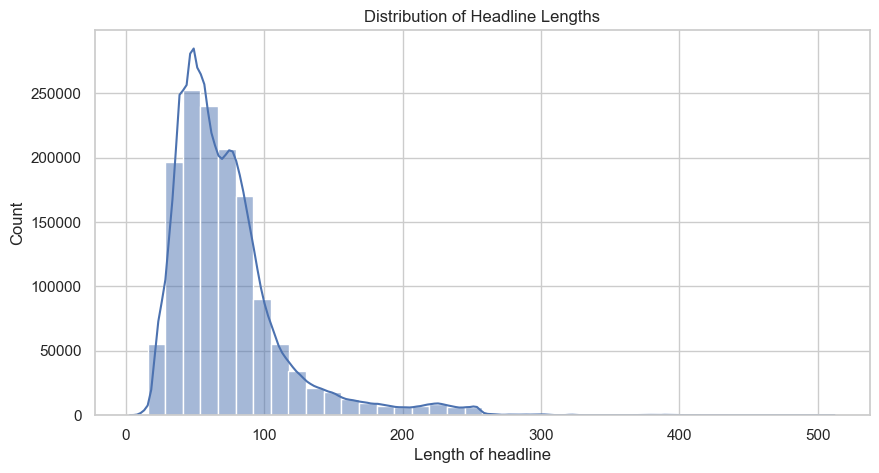

In [4]:
plt.figure(figsize=(10,5))
sns.histplot(df["headline_length"], bins=40, kde=True)
plt.title("Distribution of Headline Lengths")
plt.xlabel("Length of headline")
plt.ylabel("Count")
plt.show()


In [5]:
publisher_counts = df["publisher"].value_counts()

publisher_counts.head(20)


publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Vick Meyer            24826
webmaster             20313
Benzinga_Newsdesk     19410
Zacks                 19390
Jayson Derrick        19050
Allie Wickman         18317
Shanthi Rexaline      16640
Craig Jones           16221
Wayne Duggan          12897
Nelson Hem            12590
Name: count, dtype: int64

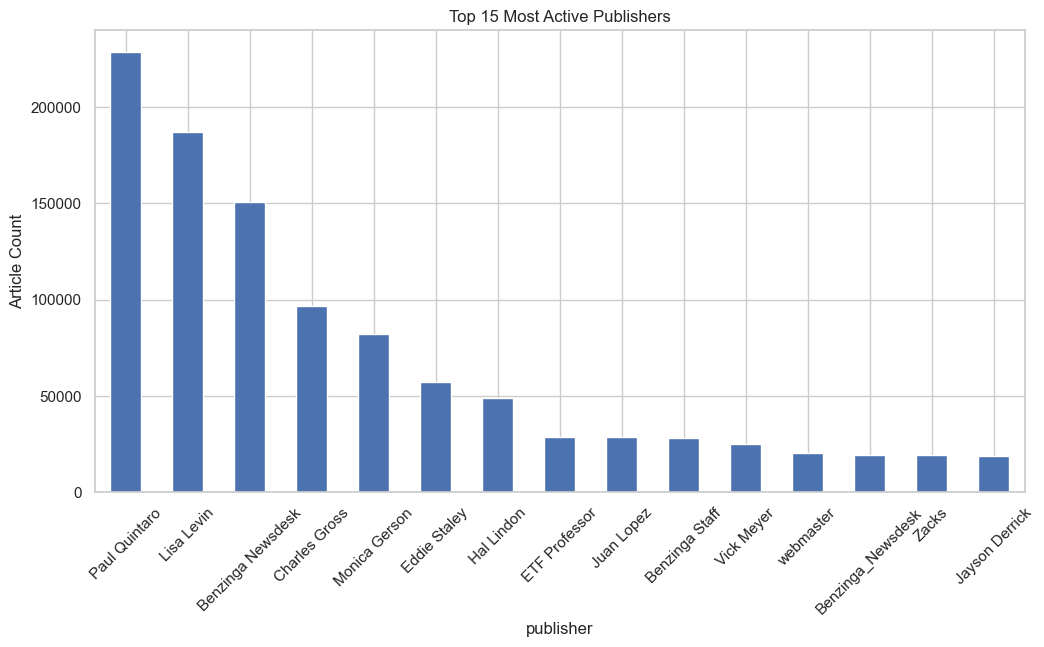

In [6]:
plt.figure(figsize=(12,6))
publisher_counts.head(15).plot(kind="bar")
plt.title("Top 15 Most Active Publishers")
plt.ylabel("Article Count")
plt.xticks(rotation=45)
plt.show()


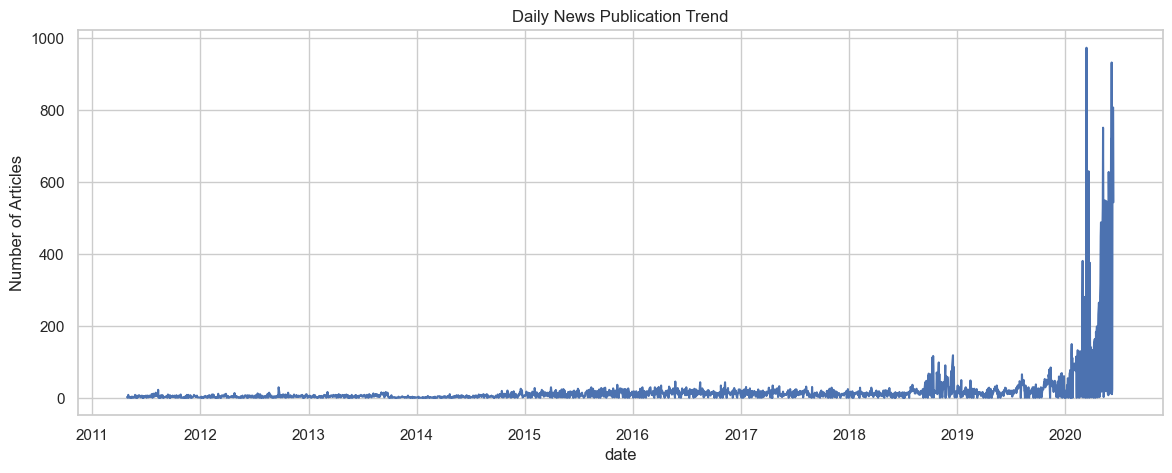

In [7]:
df_daily = df.groupby(df["date"].dt.date).size()

plt.figure(figsize=(14,5))
df_daily.plot()
plt.title("Daily News Publication Trend")
plt.ylabel("Number of Articles")
plt.show()


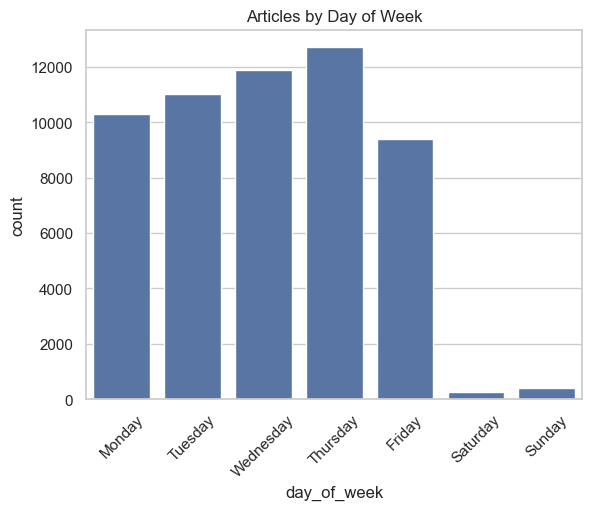

In [8]:
df["day_of_week"] = df["date"].dt.day_name()

sns.countplot(data=df, x="day_of_week", order=[
    "Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"
])
plt.title("Articles by Day of Week")
plt.xticks(rotation=45)
plt.show()


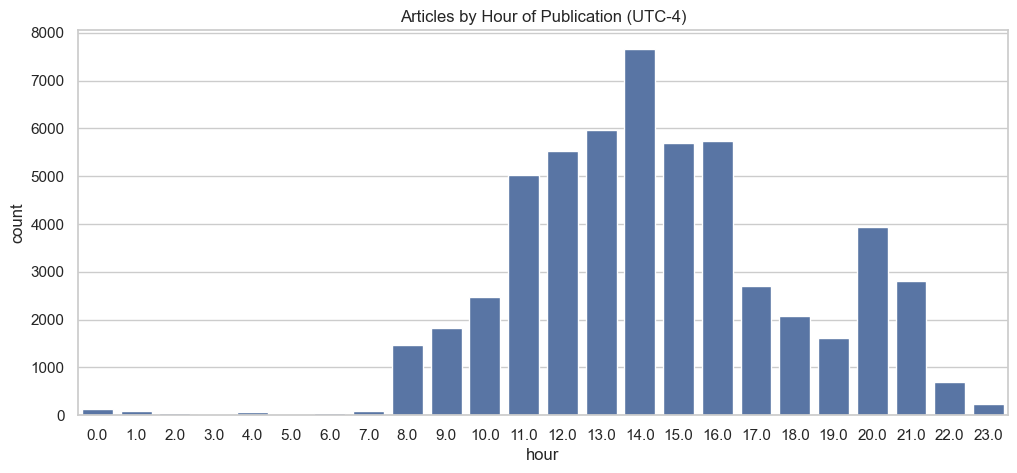

In [9]:
df["hour"] = df["date"].dt.hour

plt.figure(figsize=(12,5))
sns.countplot(data=df, x="hour")
plt.title("Articles by Hour of Publication (UTC-4)")
plt.show()


In [10]:
stop = stopwords.words("english")
vectorizer = CountVectorizer(
    stop_words=stop,
    max_features=40
)

bag = vectorizer.fit_transform(df["headline"])
word_freq = dict(zip(vectorizer.get_feature_names_out(), bag.sum(axis=0).A1))

word_freq


{'00': np.int64(47468),
 '10': np.int64(40630),
 '52': np.int64(56972),
 'announces': np.int64(66591),
 'benzinga': np.int64(74516),
 'buy': np.int64(64371),
 'day': np.int64(46141),
 'downgrades': np.int64(61959),
 'earnings': np.int64(87399),
 'eps': np.int64(128897),
 'est': np.int64(140604),
 'estimate': np.int64(37944),
 'higher': np.int64(48286),
 'inc': np.int64(45179),
 'maintains': np.int64(52961),
 'market': np.int64(120558),
 'mid': np.int64(62263),
 'moving': np.int64(42289),
 'new': np.int64(48228),
 'price': np.int64(64407),
 'pt': np.int64(73068),
 'q1': np.int64(38653),
 'q2': np.int64(37701),
 'q4': np.int64(40571),
 'raises': np.int64(57802),
 'reports': np.int64(108710),
 'sales': np.int64(79645),
 'says': np.int64(43133),
 'sees': np.int64(37979),
 'session': np.int64(45349),
 'shares': np.int64(114313),
 'stock': np.int64(39760),
 'stocks': np.int64(161776),
 'target': np.int64(54714),
 'top': np.int64(79632),
 'trading': np.int64(61182),
 'update': np.int64(91723)

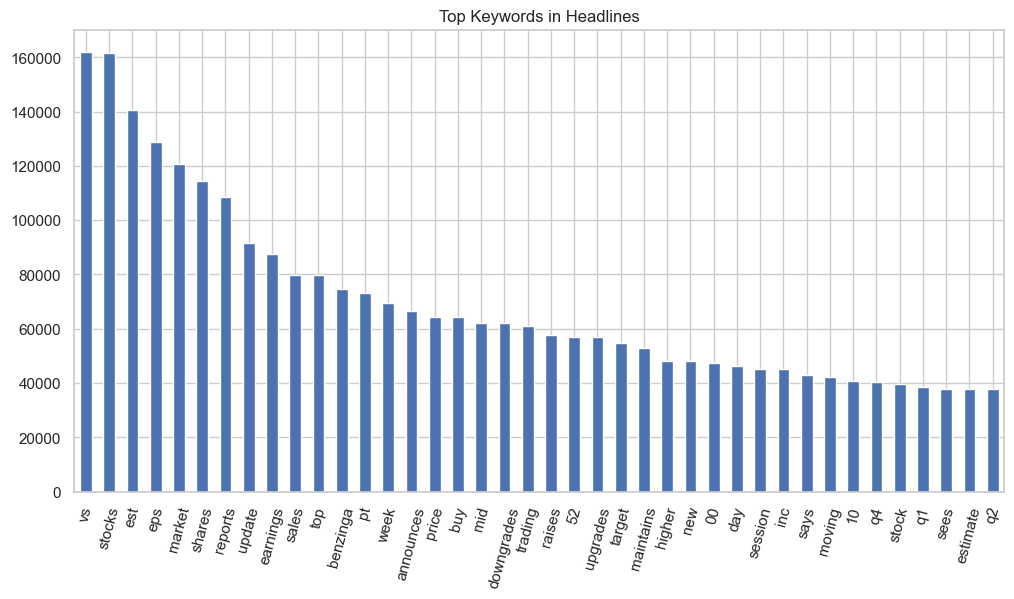

In [11]:
plt.figure(figsize=(12,6))
pd.Series(word_freq).sort_values(ascending=False).plot(kind="bar")
plt.title("Top Keywords in Headlines")
plt.xticks(rotation=75)
plt.show()


In [12]:
vectorizer = CountVectorizer(
    max_df=0.9,
    min_df=10,
    stop_words="english"
)
X = vectorizer.fit_transform(df["headline"])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

for idx, topic in enumerate(lda.components_):
    print(f"\nTOPIC #{idx+1}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])



TOPIC #1:
['highest', 'low', 'set', 'etfs', 'industry', 'watch', '52', 'new', 'week', 'stocks']

TOPIC #2:
['52', 'downgrades', 'upgrades', 'movers', 'morgan', 'stocks', 'week', 'scheduled', 'benzinga', 'earnings']

TOPIC #3:
['blog', 'deal', 'energy', 'new', 'analyst', 'update', 'reports', 'shares', 'announces', 'says']

TOPIC #4:
['q3', 'q2', 'estimate', 'q4', 'q1', 'sales', 'reports', 'eps', 'est', 'vs']

TOPIC #5:
['trading', 'maintains', 'target', 'mid', 'price', 'buy', 'update', 'pt', 'shares', 'market']


In [13]:
def extract_domain(x):
    if isinstance(x, str) and "@" in x:
        return x.split("@")[-1]
    return "unknown"

df["publisher_domain"] = df["publisher"].apply(extract_domain)

df["publisher_domain"].value_counts().head(10)


publisher_domain
unknown                   1399240
benzinga.com                 7937
gmail.com                     139
andyswan.com                    5
investdiva.com                  2
tothetick.com                   2
eosdetroit.io                   1
forextraininggroup.com          1
stockmetrix.net                 1
Name: count, dtype: int64

In [14]:
df.to_csv("../data/news_cleaned.csv", index=False)
